In [3]:
import random
import requests
import csv
import pandas as pd
import math
import numpy as np
type(np.int32(np.atleast_1d(np.int32(0))))
from operator import attrgetter
import matplotlib.pyplot as plt
print("Ok")

Ok


In [5]:
"""応答関数読み込む"""
a = pd.read_csv("20knot_wide_ver2.csv", encoding="shift_jis")#widly_20_Sym:shift_jis
strip =a.values
#b = pd.read_csv("wave_statistics.csv", encoding="shift_jis",header=None)#widly_20_Sym
#wave_statistics =b.values
print(np.shape(strip))
#print(np.shape(wave_statistics))
#print(wave_statistics[0])

(5760, 26)


In [6]:
"""諸々の定義"""
n_fruid  = 1    #速度６種類
n_angle  = 72   #0~350まで36パターン 0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,
n_lambda = 80   #波長40パターン
Iy = 2661319053 #mm^2*m^2
y_y = 17.612 #[m] 中立軸
Zc=66.122#82.211#66.122*10**6#82.211[m^3]をなんじゃない？
kissui=15.7
interval=0.03

omegalist=[]
for i in range(n_lambda):
    omegalist.append(strip[i][3])
omegalist=np.array(omegalist)#freq_JWA[::-1]
encount_omega_2 = np.arange( 0, 2.11,interval )

In [7]:
class Wave_Spectrum:    
    def __init__(self):
        self.Hv_1    =Hv_1
        self.theta_1 =theta_1
        self.lambda_1=lambda_1
        self.omega_1 =omega_1
        #self.S_max1  =0
        
        self.Hv_2    =Hv_2
        self.theta_2 =theta_2
        self.lambda_2=lambda_2
        self.omega_2 =omega_2
        #self.S_max2  =0
    
    def def_S_max(self,H,omega_m):
        HL=H/(1.56*4*math.pi**2/omega_m**2)
        """波集中度s1の周波数依存"""
        if H==0:
            S_max=0
        elif HL<0.026:
            log_10=0.4444*math.log10(HL)+0.5849
            a=10**(log_10)
            S_max=12.99*a**(-2.5)     
        elif HL>=0.026:
            log10_gF=(0.1507-math.sqrt(0.1507**2+4*0.005882*0.8789+4*0.005882*math.log10(HL)))/(2*0.005882)
            gF=10**log10_gF
            gT=1.37*(1-1/(1+0.008*gF**(1/3))**5)
            S_max=12.99*gT**2.5
        return np.array([(S_max*i**5/omega_m**5) if i<=omega_m else (S_max*i**(-2.5)/omega_m**(-2.5)) for i in omegalist])#S_max
        
    def A(self,x):
        """ガンマ関数×2^(2s-1)÷π"""
        if x >= 84:
            direction_m=np.prod([2*(x-k)/(2*x-2*k-1) for k in range(int(x))])*2**(2*x-2*int(x)-1)*(math.gamma(x-int(x)+1))**2.0/(np.pi*math.gamma(2*x-2*int(x)+1))
        else:
            direction_m=2.0**(2.0*x-1.0)*(math.gamma(x+1.0))**2.0/math.pi/math.gamma(2.0*x+1.0)
        return direction_m
    
    def spectrum(self,Hv_m,lambda_m,omega_m,omega):
        """2π掛けてること忘れずに"""
        spectrum_1=0.250*((4.0*lambda_m+1.0)/4.0*omega_m**4.0)**lambda_m*Hv_1**2.0/omega**(4.0*lambda_m+1.0)/math.gamma(lambda_m)
        spectrum_2=math.exp(-(4.0*lambda_m+1.0)/4.0*(omega_m/omega)**4.0)
        return spectrum_1*spectrum_2
    
    def Direc(self,s_m,theta_m,theta_c):
        """2次元方向分布の値の計算"""
        #180-theta_m+theta_c
        return np.array([[abs(math.cos((theta_c-theta_m-180-j*360/n_angle)/2.0*math.pi/180.0))**(2.0*s_m[i]) for j in range(n_angle)] for i in range(n_lambda)])

    def Directional_wave_spectrum(self,theta_c):       
        """S_maxの計算とsの関数の計算"""
        s_1,s_2 =self.def_S_max(self.Hv_1,self.omega_1),self.def_S_max(self.Hv_2,self.omega_2)
        """周波数方向のスペクトルの値の計算"""
        Ochi_A_1=[self.spectrum(self.Hv_1,self.lambda_1,self.omega_1,omegalist[i])*self.A(s_1[i]) for i in range(n_lambda)]
        Ochi_A_2=[self.spectrum(self.Hv_2,self.lambda_2,self.omega_2,omegalist[i])*self.A(s_2[i]) for i in range(n_lambda)]
        """2次元方向分布の値の計算"""
        Direc_1=self.Direc(s_1,self.theta_1,theta_c)*(360/n_angle)*np.pi/180
        Direc_2=self.Direc(s_2,self.theta_2,theta_c)*(360/n_angle)*np.pi/180
        """配列の積と二峰分のエネルギーの和"""
        Spectrum_2D = np.expand_dims(Ochi_A_1,1)*Direc_1 + np.expand_dims(Ochi_A_2,1)*Direc_2#np.expand_dimsで1次元配列を25行1列の配列にした後，ブロードキャスト
        return [[Spectrum_2D[i][j] for j in range(n_angle)] for i in range(n_lambda)]


class Data_Handling(Wave_Spectrum):
    def __init__(self,column1,column2):
        self.column1=column1
        self.column2=column2
        self.response1=strip[:][self.column1]
        self.response2=strip[:][self.column2]
        self.Se_data=[]
        self.S_data=[]
        self.z1= 1000*9.8065/Zc/10**6 if column1 == 17 else 1  #1000*9.8065/Zc[m^3]/10^6なんじゃない？#1000*9.8065/Zc
        self.z2= 1000*9.8065/Zc/10**6 if column2 == 17 else 1  #1000*9.8065/Zc
        self.Matrix=np.array([[0 for k in range(2)] for l in range(len(encount_omega_2))], dtype = 'float64')
        #self.omega_vertex=
        self.V  =Fn*math.sqrt(349.2*9.80655)
    
    def Response_calculation(self,line1):
        X_Conjugate = strip[line1][self.column1]*(math.cos(-strip[line1][self.column1+1]*math.pi/180)+1j*math.sin(-strip[line1][self.column1+1]*math.pi/180))
        Y= strip[line1][self.column2]*(math.cos(strip[line1][self.column2+1]*math.pi/180)+1j*math.sin(strip[line1][self.column2+1]*math.pi/180)) 
        return X_Conjugate*Y #strip[line1][self.column1]*strip[line1][self.column1]#
    
    def dw_function(self,omega_number):
        return np.abs(1.0-2.0*self.V/9.80655*omegalist[omega_number]*math.cos(encount_angle*math.pi/180.0))        
    
    def To_trans_Se(self,line,w,j,switch,Eomega1):#Eomega1,2=Eomega_fore,aft
        """線形補間"""  
        Sf_re,Sa_re=self.Response_calculation(line).real*wave_values[w][j],self.Response_calculation(line-1).real*wave_values[w-1][j]
        Sf_im,Sa_im=self.Response_calculation(line).imag*wave_values[w][j],self.Response_calculation(line-1).imag*wave_values[w-1][j]
        dw= omegalist[w]-omegalist[w-1]
        if len(list_omega_j) == 0 and Eomega1 < np.max(encount_omega_2):
            self.Matrix[int(Eomega1/interval)][0] += (Sa_re+Sf_re)*np.abs(omegalist[w]-omegalist[w-1])/2/interval
            self.Matrix[int(Eomega1/interval)+1][0] += (Sa_re+Sf_re)*np.abs(omegalist[w]-omegalist[w-1])/2/interval
            self.Matrix[int(Eomega1/interval)][1] += (Sa_im+Sf_im)*np.abs(omegalist[w]-omegalist[w-1])/2/interval
            self.Matrix[int(Eomega1/interval)+1][1] += (Sa_im+Sf_im)*np.abs(omegalist[w]-omegalist[w-1])/2/interval
            
        for w_e in list_omega_j:        
            if switch == 1: #頂点のx座標が挟まれる場合
                self.Matrix[w_e][0] += (Sa_re+Sf_re)*dw/2/(omega_vertex/2-min(Eomega1,Eomega2))
                self.Matrix[w_e][1] += (Sa_im+Sf_im)*dw/2/(omega_vertex/2-min(Eomega1,Eomega2))
            elif switch == 2: #x軸との交点が挟まれる場合
                self.Matrix[w_e][0] += (Sa_re+Sf_re)*dw/2/max(Eomega1,Eomega2)
                self.Matrix[w_e][1] += (Sa_im+Sf_im)*dw/2/max(Eomega1,Eomega2)
            else:
                dwe1 = self.dw_function(w-1)
                dwe2 = self.dw_function(w)
                self.Matrix[w_e][0] +=(Eomega2-encount_omega_2[w_e])/(Eomega2-Eomega1)*Sa_re/dwe1+(encount_omega_2[w_e]-Eomega1)/(Eomega2-Eomega1)*Sf_re/dwe2
                self.Matrix[w_e][1] +=(Eomega2-encount_omega_2[w_e])/(Eomega2-Eomega1)*Sa_im/dwe1+(encount_omega_2[w_e]-Eomega1)/(Eomega2-Eomega1)*Sf_im/dwe2
            
    def final_keisan(self):
        F =np.zeros(len(encount_omega_2))
        for w_e in range(len(encount_omega_2)):
            F[w_e] += math.sqrt(self.Matrix[w_e][0]**2+self.Matrix[w_e][1]**2)*self.z1*self.z2
        plt.plot(encount_omega_2,F,'-o')
        plt.grid()
        plt.xlabel('ω[rad/s]')
        plt.show()
        return F
    
    def X_final_keisan(self):
        """足し合わせたベクトルの角度"""
        F_Re=self.Matrix[w_e][0]*self.z1*self.z2
        F_Im=self.Matrix[w_e][1]*self.z1*self.z2
        


"""ここからはクラスによらないdef関数が続く"""
def get_parameter_from_ind():
    """波高"""
    Hv_1=0.5+13.5*random.uniform(0,1)
    Hv_2= (0.01*Hv_1**2.3+0.5) +((5*(0.9*Hv_1**2-0.44*Hv_1)**0.1)-(0.01*Hv_1**2.3+0.5))*random.uniform(0,1)
    Hs    =np.sqrt(Hv_1**2+Hv_2**2)
    
    """波周波数"""
    omega_1 = 2*np.pi/16*np.exp(-0.005*Hs*3.28084)+(2*np.pi/6*np.exp(-0.017*Hs*3.28084)-2*np.pi/16*np.exp(-0.005*Hs*3.28084))*random.uniform(0,1)
    w_lower = omega_1 if omega_1>=0.6 else 0.6
    omega_2 = w_lower+(2*np.pi/4*np.exp(-0.014*Hs*3.28084)-w_lower)*random.uniform(0,1)
        
    """波向"""
    theta_1  =random.random()*360
    theta_2  =random.random()*360
    
    """s"""
    #S_max1=
    #S_max2=
    
    """尖度"""
    lambda_1 =0.1+9.9*random.uniform(0,1)
    lambda_temp=lambda_1 if lambda_1<=6 else 6
    lambda_2 =0.1+(lambda_temp-0.1)*random.uniform(0,1)

    """
    omega_1 = 2*np.pi/14 + (1.2-2*np.pi/14)*random.random()
    Wm2_min =omega_1 if omega_1>=0.6 else 0.6
    omega_2 =Wm2_min+(2*np.pi/4-Wm2_min)*random.random()

    T1      =2*np.pi/omega_1
    T2      =2*np.pi/omega_2
    Hv_1    =strip_data[int(T1)-4][24]+(strip_data[int(T1)-4][25]-strip_data[int(T1)-4][24])*random.random()
    H2_max  =np.sqrt(15**2-Hv_1**2) if np.sqrt(Hv_1**2+strip_data[int(T2)-4][25]**2)>=15 else strip_data[int(T2)-4][25]
    H2_min  =strip_data[int(T2)-4][24]
    Hv_2    = H2_min+(H2_max-H2_min)*random.random()"""

    Hv_1,theta_1,lambda_1,omega_1,Hv_2,theta_2,lambda_2,omega_2=2.37,-75.41108127,0.85,0.47,2.54,-154.4400348,2.05,0.695
    return Hv_1,theta_1,lambda_1,omega_1,Hv_2,theta_2,lambda_2,omega_2#S_max1,S_max2

def search_omega_i(i):
    """間に入る出会い波周波数のリスト作成"""
    Eomega1=np.abs(omegalist[i-1]*(1-Fn*math.sqrt(349.2*9.80655)/9.80655*omegalist[i-1]*math.cos(encount_angle*math.pi/180)))
    Eomega2=np.abs(omegalist[i]*(1-Fn*math.sqrt(349.2*9.80655)/9.80655*omegalist[i]*math.cos(encount_angle*math.pi/180)))
    Eomega_fore = max(Eomega1,Eomega2)
    Eomega_aft =  min(Eomega1,Eomega2)
    switch=0#0は通常，１は頂点が挟まれる，２はｘとの交点が挟まれる
    if (omega_vertex - omegalist[i-1])*(omega_vertex -omegalist[i]) <= 0.000: #頂点のx座標が挟まれる場合
        Eomega_fore = omega_vertex/2 #頂点のy座標はx座標の半分だから
        switch=1
    elif (omega_vertex*2 - omegalist[i-1])*(omega_vertex*2 -omegalist[i]) <= 0: #x軸との交点が挟まれる場合
        Eomega_aft = np.abs(0.0)
        switch=2
    return np.arange(len(encount_omega_2))[np.array( (encount_omega_2-Eomega_fore)*(encount_omega_2-Eomega_aft) <= 0 ).flatten()] ,Eomega1, Eomega2,switch

(80, 72)


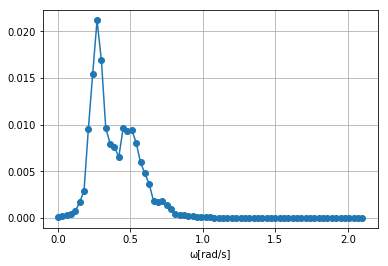

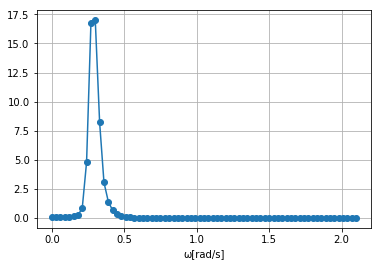

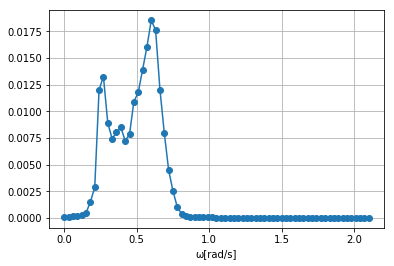

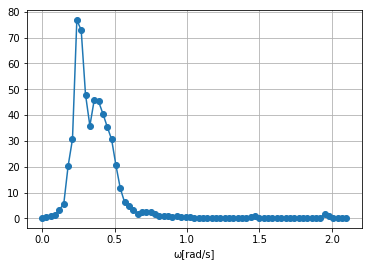

In [13]:
for seastate in range(1): 
    random.seed()
    """この海象のパラメータ"""
    Hv_1,theta_1,lambda_1,omega_1,Hv_2,theta_2,lambda_2,omega_2 =3.16,-88,1.21,0.815,1.07,-100,0.745,1.79
    #4.27,-78.7,1.18,0.65,1.42,-123.9,0.97,0.785
    #get_parameter_from_ind()#S_max1,S_max2
    theta_course=81#287#
    """相対波向きに注意"""
    wave=Wave_Spectrum()
    #wave.S_max1=32.37
    #wave.S_max2=6.23
    
    for speed in range(1): #6フルード数ごと 0,5,10,15,20,25
        Fn    = 0.176*0.9#strip_data[n_lambda*n_angle*k][0]#フルード数
        wave_values=wave.Directional_wave_spectrum(theta_course)
        print(np.shape(wave_values))
        
        """データを扱うためのクラス"""
        Pitch=Data_Handling(13,13)#13
        Roll =Data_Handling(11,11)
        Heave=Data_Handling( 9, 9)
        Load =Data_Handling(17,17)#zを乗算するところのif分で列番号直すの忘れずに！
        #Pitch_Roll  =Data_Handling(13,11)
        #Roll_Heave  =Data_Handling(11, 9)
        #Heave_Pitch =Data_Handling( 9,13)
        #Load_Roll   =Data_Handling(17,11)
        #Load_Heave  =Data_Handling(17, 9)
        #Load_Pitch  =Data_Handling(17,13)
        
        for j,encount_angle in enumerate(np.arange(0,360,360/n_angle)): #36の角度          
            omega_vertex  = 9.80655/(2*Fn*math.sqrt(349.2*9.80655)*math.cos(encount_angle*math.pi/180)) #頂点のx座標
            
            for w in range(1,len(omegalist)): #25周波数ごと n_lambda
                line = w+n_lambda*j+n_lambda*n_angle*speed    #行           
                list_omega_j,Eomega1, Eomega2,switch = search_omega_i(w)
                """それぞれの応答で変換実行"""
                Pitch.To_trans_Se(line,w,j,switch,Eomega1)#注意！！複素数ではなく純虚数対応になってるよ
                Roll.To_trans_Se(line,w,j,switch,Eomega1)
                Heave.To_trans_Se(line,w,j,switch,Eomega1)
                Load.To_trans_Se(line,w,j,switch,Eomega1)
                #Pitch_Roll.To_trans_Se()
                #Roll_Heave.To_trans_Se()
                #Heave_Pitch.To_trans_Se()
                #Load_Roll.To_trans_Se()
                #Load_Heave.To_trans_Se()
                #Load_Pitch.To_trans_Se()
        """最終アウトプット"""        
        Pitch_ver3 =Pitch.final_keisan()
        Roll_ver3 =Roll.final_keisan()
        Heave_ver3=Heave.final_keisan()
        Load_ver3 =Load.final_keisan()
        #Pitch_Roll.X_final_keisan()
        #Roll_Heave.X_final_keisan()
        #Heave_Pitch.X_final_keisan()
        #Load_Roll.X_final_keisan()
        #Load_Heave.X_final_keisan()
        #Load_Pitch.X_final_keisan()
    #print(SeaState+1)

In [18]:
f=open('FALCON_201911131000_stress_by_calculation.csv',"w")
for i in range(len(Load_ver3)):
    f.write(str(encount_omega_2[i])+","+str(Heave_ver3[i]))
    f.write('\n')
f.close()
print("End")

End


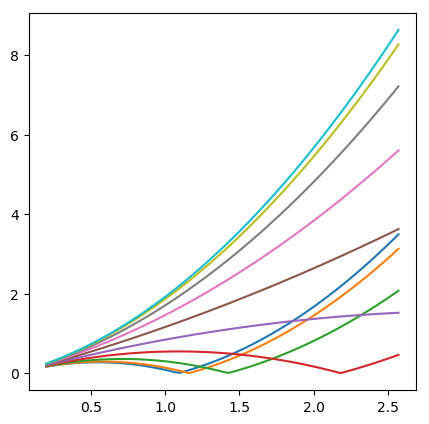

In [6]:
plt.figure(figsize=(5, 5), dpi=100)
for kakudo in range(10):
    plt.plot(omegalist,[np.abs(a - a**2/9.81*9*np.cos(kakudo*20*np.pi/180)) for a in omegalist])

(80, 72)
(80, 72)


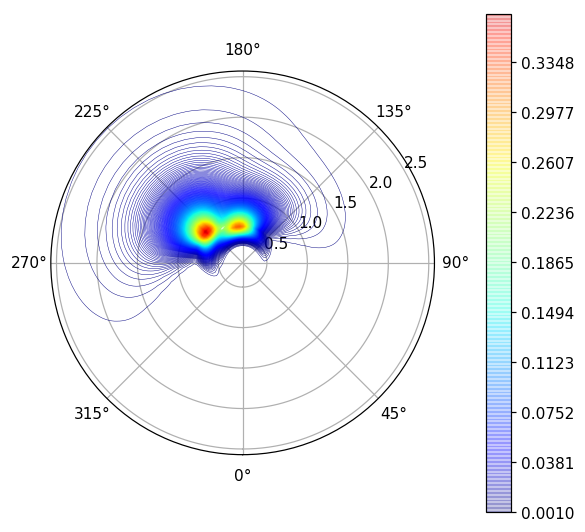

Target


In [7]:
from matplotlib.cm import ScalarMappable
import matplotlib.colors as colors
import matplotlib.cm as cm
import pandas as pd
from matplotlib.colors import Normalize


fig2 = plt.figure(figsize=(6,6),dpi=110)
#ax2 = fig2.add_subplot(111, projection="polar")
ax2 = fig2.add_subplot(111, projection="polar")

r = np.arange(0, 360,5)
theta = 2 * np.pi/360*r
freq=omegalist#np.array([0.0445953,0.0486315,0.053033,0.0578329,0.0630672,0.0687753,0.075,0.0817881,
                 # 0.0891906,0.097263,0.106066,0.1156658,0.1261345,0.1375506,0.15,0.1635762,0.1783811,
                 # 0.194526,0.2121321,0.2313317,0.252269,0.2751013,0.3000001,0.3271524,0.3567623]) #np.arange(0, 1.0, 0.1)

#wavedate=pd.read_csv("sample.csv", encoding="shift_jis",engine="python")#
wavedata=wave_values#[[float(wavedate.iloc[i][j+1])for j in range(37)] for i in range(25)]#wavedate.values[0:25,1:37]
X, Y = np.meshgrid(theta, freq)
print(np.shape(X))
print(np.shape(Y))
H=wavedata#X**2+Y**2
v = np.linspace(0., 0.4, 400)#, endpoint=True)
ctf=ax2.contour(X, Y, H,levels=v,cmap=cm.jet,linewidths=0.3,vmax=0.4)#, norm=Normalize(vmin=0, vmax=40)
plt.colorbar(ctf, pad=0.1,orientation="vertical")#colb = , 
#colb.set_clim(0,40)
ax2.set_theta_zero_location("S")#JWAに合わせてる
ax2.set_theta_direction(1)#時計回り
ax2.set_rlabel_position(120)#距離の軸の位置
#ax2.set_rlabel_position(-2)#カラーバーのオフセット

plt.show()
print("Target")